<h2>Processamento de Dados</h2>

Agora vamos fazer algumas alterações em nosso dataset para prosseguirmos com nossa análise. Esse processo é chamado também de limpeza de dados.

### Sumário:

-   [1. Carregando bibliotecas e Dataset](#cell1)
-   [2. Valores NA](#cell2)
-   [3. Normalizando Dados](#cell3)
-   [4. Variável Indicadora](#cell4)

<h3>Carregando Biblioteca e Dataset</h3>

Vamos primeiramente carregar os dados e ferramentas que precisamos.

In [5]:
# Carrega tidyverse

library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


A empresa IBM, mantém em seu site uma série de conjunto de dados. Nesse caso usaremos o <a href="https://developer.ibm.com/exchanges/data/all/airline/">Airline Dataset</a> que contém dados de mais de 200 milhões de voos domésticos feitos em território americano, coletados pelo Departamento de Estatísticas de Transporte dos Estados Unidos. Por questões didáticas usaremos a amostra desses dados e não o arquivo inteiro.

<ul>
    <li>data source: <a href="https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz" target="_blank">https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz</a></li>
    <li>data type: csv</li>
</ul>

In [17]:
# url onde os dados estão localizados
# url <- "https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz"

# download do arquivo
#download.file(url, destfile = "lax_to_jfk.tar.gz")

# extrair arquivo 
# remova tar = "internal se estiver rodando este programa localmente" 
# untar("lax_to_jfk.tar.gz", tar = "internal")

# Lemos o arquivo csv => read_csv (Se for de um formato diferente use a função apropriada, verifique a documentação de readr)
companhias_aereas <- read_csv("dados/losAngeles_para_novaYork.csv",
                     col_types = cols(
                      'DivDistance' = col_number(),
                      'DivArrDelay' = col_number()
                      ))

<h3>Valores NA e Formatação</h3>

- `NA`: Quando um valor está faltando no dataset a linguagem R atribui o símbolo NA (Not Available) a ele.
- `NAN`: Valores impossíveis, como divisão por 0, são representados por NaN(not a number).

Podemos usar a função `is.na(x)`, para saber se um elemento x é NA.





In [18]:
# Observamos que há uma série de dados faltando no dataset

head(companhias_aereas)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA


In [19]:
# Contamos a quantidade de valores faltando no dataset
companhias_aereas %>%
  summarize(count = sum(is.na(CarrierDelay)))

count
<int>
2486


Vamos usar `purrr::map()` para contar valores NA em cada coluna. 

`map()` aplica uma função ou fórmula num elemento

-   O símbolo `~` separa o lado esquerdo do direito da fórmula. Geralmente fórmulas são representadas assim: `y ~ x`, no exemplo a seguir de `map()`, usaremos uma função que só precisa do lado direito: sum(is.na(.))
-   O `.` representa cada coluna no dataset. 

Verifique a documentação `?map` e `?formula`, para mais informações.

In [20]:
# Aplique a função sum(is.na(.)) para cada coluna.
# Em outras palavras, encontre a soma dos valores NA de cada coluna.

map(companhias_aereas, ~sum(is.na(.)))

$Month
[1] 0

$DayOfWeek
[1] 0

$FlightDate
[1] 0

$Reporting_Airline
[1] 0

$Origin
[1] 0

$Dest
[1] 0

$CRSDepTime
[1] 0

$CRSArrTime
[1] 0

$DepTime
[1] 0

$ArrTime
[1] 0

$ArrDelay
[1] 0

$ArrDelayMinutes
[1] 0

$CarrierDelay
[1] 2486

$WeatherDelay
[1] 2486

$NASDelay
[1] 2486

$SecurityDelay
[1] 2486

$LateAircraftDelay
[1] 2486

$DepDelay
[1] 0

$DepDelayMinutes
[1] 0

$DivDistance
[1] 2855

$DivArrDelay
[1] 2855

In [21]:
# Checamos as dimensões do dataset

dim(companhias_aereas)

[1] 2855   21

Temos em nosso dataset as seguintes linhas de valores NA.

<ol>
    <li>"CarrierDelay": 2486 dados faltando</li>
    <li>"WeatherDelay": 2486 dados faltando</li>
    <li>"NASDelay": 2486 dados faltando</li>
    <li>"SecurityDelay" : 2486 dados faltando</li>
    <li>"LateAircraftDelay": 2486 dados faltando</li>
    <li>"DivDistance": 2855 dados faltando</li>
    <li>"DivArrDelay": 2855 dados faltando</li>
</ol>

Há algumas formas de lidar com valores NA. Nesse caso, faremos uma demonstração de como removê-los do dataset

In [22]:
# Vamos armazenar em colunas_NA nosso dataset sem as colunas DivDistance e DivArrDelay
colunas_NA <- companhias_aereas %>% select(-DivDistance, -DivArrDelay)

# Dimensões do dataset
dim(colunas_NA)

# Imprime as primeiras linhas do dataset
head(colunas_NA)

[1] 2855   19

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,ArrDelay,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,2,2,NA,NA,NA,NA,NA,-1,0
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,-21,0,NA,NA,NA,NA,NA,4,4
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,-14,0,NA,NA,NA,NA,NA,-8,0
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,-3,0,NA,NA,NA,NA,NA,7,7
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,-13,0,NA,NA,NA,NA,NA,-4,0
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,-20,0,NA,NA,NA,NA,NA,2,2


Vamos verificar o tipo de dado usado em cada coluna, assim podemos nos certificar que eles estão no formato correto. Para isso usaremos algumas funções do pacote `dplyr`.


| dplyr function |        _all       |              _if |
| ------------- | :---------------: | ---------------: |
| mutate        |   `mutate_all()`  |    `mutate_if()` |
| filter        |   `filter_all()`  |    `filter_if()` |
| group_by      |  `group_by_all()` |  `group_by_if()` |
| summarize     | `summarize_all()` | `summarize_if()` |

O uso de `_all` nas funções significa a sua aplicação em todas as variáveis e o `_if` somente se determinada função é `TRUE`

In [23]:
# Mostre as classes de cada variável no dataset companhias_aereas

companhias_aereas %>% 
    summarize_all(class) %>% 
    gather(variable, class)

variable,class
<chr>,<chr>
Month,numeric
DayOfWeek,numeric
FlightDate,Date
Reporting_Airline,character
Origin,character
Dest,character
CRSDepTime,character
CRSArrTime,character
DepTime,character


In [24]:
# Para futuras análises cada dado deve estar no devido formato
# Aqui pegamos a coluna FlightDate e a desmembramos nas colunas ano, mês e dia

datas_de_voo <- companhias_aereas %>% 
    separate(FlightDate, sep = "-", into = c("year", "month", "day"))

head(datas_de_voo)

Month,DayOfWeek,year,month,day,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003,03,28,UA,LAX,JFK,2210,0615,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018,11,29,AS,LAX,JFK,1045,1912,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015,08,28,UA,LAX,JFK,0805,1634,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003,04,20,DL,LAX,JFK,2205,0619,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005,11,30,UA,LAX,JFK,0840,1653,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992,04,06,UA,LAX,JFK,1450,2308,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA


In [25]:
# Por último, observamos que as colunas ano, mês e dia estão representadas como caracteres
# Iremos modificá-los para inteiros
# A função abaixo pode ser traduzida como:
# "Modifique todos os valores nas colunas ano,mês e dia se eles forem caracteres"

datas_de_voo %>%
    select(year, month, day) %>%
    mutate_all(type.convert) %>%
    mutate_if(is.character, as.numeric)

year,month,day
<int>,<int>,<int>
2003,3,28
2018,11,29
2015,8,28
2003,4,20
2005,11,30
1992,4,6
2012,12,3
2004,12,1
1997,2,13


<h3>Normalizando Dados</h3>

É o processo de trazer dados distintos para um mesmo "alcance". Suponha, por exemplo, que você queira comparar idades de pessoas com seus respectivos salários. Este tipo de dado (salário) invariávelmente teria mais peso no modelo de análise. A fim de solucionar esse problema vamos usar a distribuição normal que é dada pela seguinte fórmula:

$$x_{new} = \frac{x_{old} - \mu}{\sigma}$$

${\mu}$: É a média dos valores

${\sigma}$: É o desvio padrão

${X}$: É uma variável qualquer.

Geralmente o resultado é uma série de valores variando de 0 a 1.



In [26]:
# Usaremos a coluna ArrDelay 
# No código abaixo mean() calcula a média de ArrDelay e sd() o seu desvio padrão.
# Os dados são armazenados em escala_Z 
# Por fim mostramos os 6 primeiros dados normalizados de ArrDelay na tela

escala_Z <- (companhias_aereas$ArrDelay - mean(companhias_aereas$ArrDelay)) / sd(companhias_aereas$ArrDelay)
head(escala_Z)

[1] -0.04815631 -0.60922513 -0.43846505 -0.17012779 -0.41407075 -0.58483083

In [27]:
head(companhias_aereas$ArrDelay)

[1]   2 -21 -14  -3 -13 -20

<h3>Variável Indicadora</h3>

Variáveis Indicadoras são usadas para aplicarmos técnicas de análise em variáveis categóricas. Em nosso dataset, por exemplo temos siglas representando as companhias áreas, caso quissemos números em seu lugar (lembrando que eles serão somente representativos) podemos atribuir-lhes valores `dummy`

In [28]:
companhias_aereas %>%
  mutate(dummy = 1) %>% # Coluna com um valor
  spread(
    key = Reporting_Airline, # Usamos a coluna Companhias Aereas e a espalhamos
    value = dummy,
    fill = 0) %>%
  slice(1:5)

Month,DayOfWeek,FlightDate,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,ArrDelay,⋯,DivArrDelay,AA,AS,B6,DL,HP,PA (1),TW,UA,VX
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,LAX,JFK,2210,0615,2209,0617,2,⋯,NA,0,0,0,0,0,0,0,1,0
11,4,2018-11-29,LAX,JFK,1045,1912,1049,1851,-21,⋯,NA,0,1,0,0,0,0,0,0,0
8,5,2015-08-28,LAX,JFK,0805,1634,0757,1620,-14,⋯,NA,0,0,0,0,0,0,0,1,0
4,7,2003-04-20,LAX,JFK,2205,0619,2212,0616,-3,⋯,NA,0,0,0,1,0,0,0,0,0
11,3,2005-11-30,LAX,JFK,0840,1653,0836,1640,-13,⋯,NA,0,0,0,0,0,0,0,1,0


Podemos visualizar através de variáveis indicadoras o número de voos reportados por uma companhias aérea.

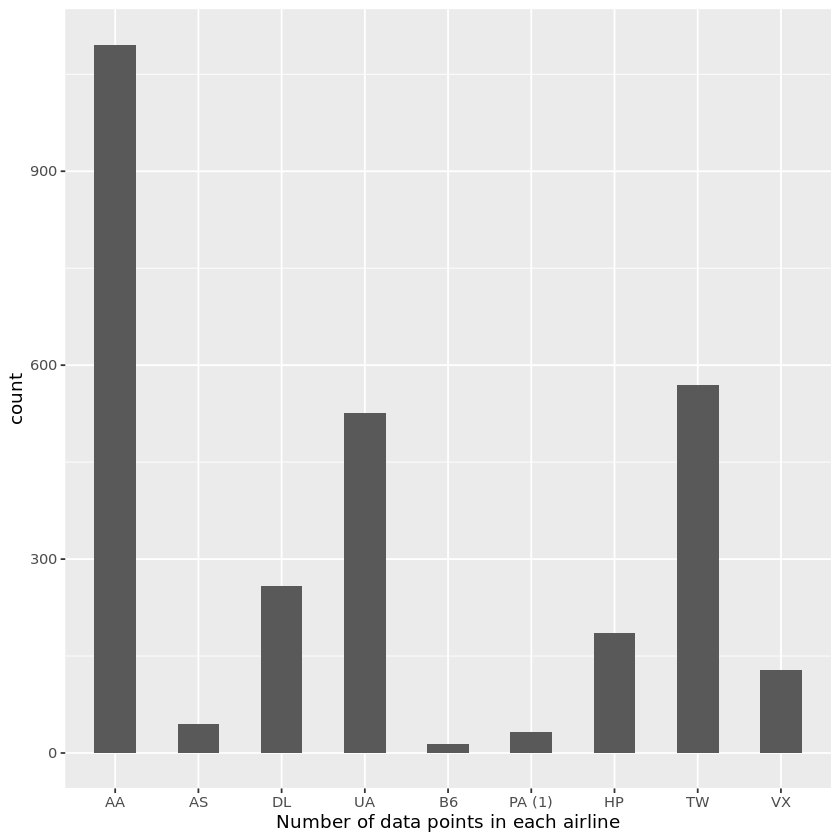

In [29]:
companhias_aereas %>% # Começamos com nosso dataset
   mutate(Reporting_Airline = factor(Reporting_Airline, #Separamos por fatores
                                     labels = c("AA", "AS", "DL", "UA", "B6", "PA (1)", "HP", "TW", "VX")))%>%
  ggplot(aes(Reporting_Airline)) + #aes() ajuda a criar gráficos estilizados
  stat_count(width = 0.5) + #ESpessura
  labs(x = "Number of data points in each airline") # Título do gráfico